In [3]:
# ===== base =====
import numpy as np
import pandas as pd

# ===== visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== sklearn: model selection =====
from sklearn.model_selection import (
    train_test_split,
    KFold,
    TimeSeriesSplit,
)

# ===== sklearn: metrics =====
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

# ===== catboost =====
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
)

# ===== pandas utils =====
from pandas.api.types import (
    is_object_dtype,
    is_categorical_dtype,
)

In [4]:
target_df = pd.read_csv('k_data.csv')
data_df = pd.read_csv('era5_data.csv')
df = pd.concat([data_df, target_df[['timestamp','HLC','Общее количество облачности']]],axis=1)
# преобразование значения наблюдений метеорологов в классы
df = df[~df['HLC'].isin([8, 9])]
df['HLC'] = df['HLC'].apply(lambda x: 1 if x != 0 else 0)
#фильтр для облаков
#df_filtered = df[
    #((df["HLC"] == 1) & (df["Общее количество облачности"] >= 8)) | #для наличия
    #((df["HLC"] == 0) & (df["Общее количество облачности"] <= 0))   #для отсутсвтия 
#]
#ручное раздеделение выборки по кускам (времени)
# сортировка по времени (Важно!)
df_filtered = df.sort_values("timestamp").reset_index(drop=True)

# 10% на тест
n = int(len(df_filtered) * 0.10)

# Тест = последние 10%
test = df_filtered.iloc[-n:]

# Валидация = 10% перед тестом
valid = df_filtered.iloc[-2*n:-n]

# Трейн = всё, что выше
train = df_filtered.iloc[:-2*n]

# Перемешиваем ТОЛЬКО train (вал + тест оставляем в хронологическом порядке!)
train = train.sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
target_df.columns

Index(['Синоптический индекс станции', 'year', 'month', 'day', 'hour',
       'Общее количество облачности', 'Количество облачности нижнего яруса',
       'HLC', 'Форма облаков среднего яруса',
       'Форма облаков вертикального развития',
       'Слоистые и слоисто-кучевые облака', 'Слоисто-дождевые облака',
       'Погода между сроками', 'Погода в срок наблюдения', 'date', 'timestamp',
       'datetime'],
      dtype='object')

HLC = High Level Cloud

In [59]:
data_df.columns

Index(['abs_humidity0', 'abs_humidity500', 'abs_humidity1000',
       'abs_humidity1500', 'abs_humidity2000', 'abs_humidity2500',
       'abs_humidity3000', 'abs_humidity3500', 'abs_humidity4000',
       'abs_humidity4500',
       ...
       'wind_direction9500', 'wind_direction10000', 'wind_direction10500',
       'wind_direction11000', 'wind_direction11500', 'wind_direction12000',
       'wind_direction12500', 'wind_direction13000', 'wind_direction13500',
       'wind_direction14000'],
      dtype='object', length=174)

Числа в названии высота, на которой наблюдаются значения. Всего 6 метеовеличин: abs_humdity, rel_humidity, temperature, pressure, wind_speed, wind_direction.

In [6]:
df = pd.concat([data_df, target_df[['timestamp','HLC','Общее количество облачности']]],axis=1)

In [7]:
# преобразование значения наблюдений метеорологов в классы
df = df[~df['HLC'].isin([8, 9])]
df['HLC'] = df['HLC'].apply(lambda x: 1 if x != 0 else 0)

In [8]:
df['HLC'].value_counts()

HLC
0    14793
1    11072
Name: count, dtype: int64

In [10]:
#фильтр для облаков
df_filtered = df[
    ((df["HLC"] == 1) & (df["Общее количество облачности"] >= 4)) | #для наличия
    ((df["HLC"] == 0) & (df["Общее количество облачности"] <= 0))   #для отсутсвтия 
]


In [11]:
df_filtered.HLC.value_counts()

HLC
1    9195
0    8198
Name: count, dtype: int64

In [14]:
#ручное раздеделение выборки по кускам (времени)
df_filtered = df.sort_values("timestamp").reset_index(drop=True)

n = int(len(df_filtered) * 0.15) #по 15%

test = df_filtered.iloc[-n:] #15% c конца

valid = df_filtered.iloc[-2*n:-n] #15% перед тестом

train = df_filtered.iloc[:-2*n] #всё что осталось

print(len(train), len(valid), len(test))

In [18]:
def cv_with_strategy(df, target_column, n_splits=5, method='sequential', model_params=None):
    # Проверяем если переданы параметры, если нет, используем параметры по умолчанию
 

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    roc_aucs = []
    
    if method not in ['sequential', 'random']:
        raise ValueError("Invalid method. Choose 'sequential' or 'random'.")

    if method == 'sequential':
        # Последовательная кросс-валидация
        fold_size = len(X) // (n_splits + 1)

        for fold in range(n_splits):
            train_end = fold_size * (fold + 1)
            test_start = train_end
            test_end = test_start + fold_size

            X_train, y_train = X[:train_end], y[:train_end]
            X_test, y_test = X[test_start:test_end], y[test_start:test_end]

            model = CatBoostClassifier(
            iterations=1000,
            loss_function='Logloss',  # Используется для бинарной классификации
            auto_class_weights='SqrtBalanced',
            verbose=0)    # Используйте * для передачи словаря в качестве именованных аргументов
            model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            roc_auc = roc_auc_score(y_test, y_pred_proba)
            roc_aucs.append(roc_auc)

            conf_matrix = confusion_matrix(y_test, y_pred)

            print(f"Sequential Fold {fold + 1}")
            print(f"ROC AUC: {roc_auc:.2f}")
            print("Confusion Matrix:")
            print(conf_matrix)
            
            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix for Sequential Fold {fold + 1}')
            plt.show()

            print(classification_report(y_test, y_pred))
            print("="*50)
    
    elif method == 'random':
        # Случайная кросс-валидация
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = CatBoostClassifier(
            iterations=1000,
            loss_function='Logloss',  # Используется для бинарной классификации
            auto_class_weights='Balanced',
            verbose=0)  # Используйте * для передачи словаря в качестве именованных аргументов
            model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            roc_auc = roc_auc_score(y_test, y_pred_proba)
            roc_aucs.append(roc_auc)

            conf_matrix = confusion_matrix(y_test, y_pred)

            print(f"Random Fold {fold + 1}")
            print(f"ROC AUC: {roc_auc:.2f}")
            print("Confusion Matrix:")
            print(conf_matrix)
            
            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix for Random Fold {fold + 1}')
            plt.show()

            print(classification_report(y_test, y_pred))
            print("="*50)

    print(f"Average ROC AUC: {np.mean(roc_aucs):.2f}")

In [19]:
c_val = pd.concat([train,valid],axis=0)

Random Fold 1
ROC AUC: 0.97
Confusion Matrix:
[[2186  286]
 [ 185 1741]]


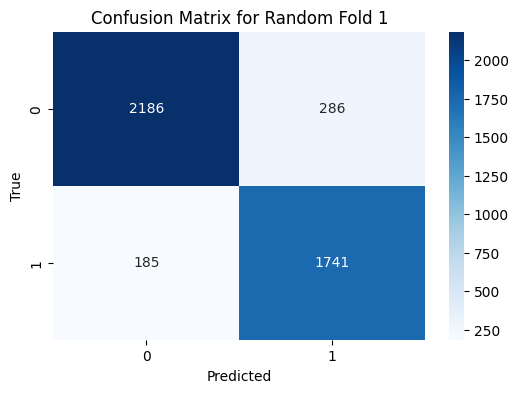

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2472
           1       0.86      0.90      0.88      1926

    accuracy                           0.89      4398
   macro avg       0.89      0.89      0.89      4398
weighted avg       0.89      0.89      0.89      4398

Random Fold 2
ROC AUC: 0.97
Confusion Matrix:
[[2202  248]
 [ 208 1739]]


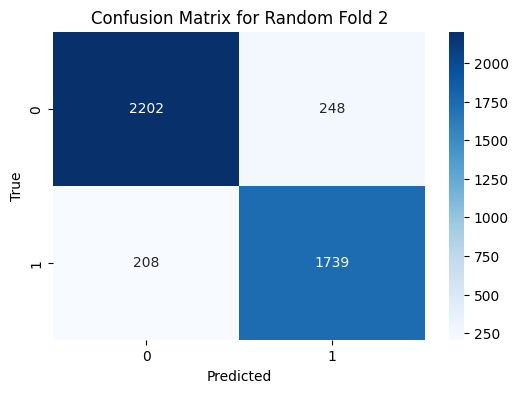

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2450
           1       0.88      0.89      0.88      1947

    accuracy                           0.90      4397
   macro avg       0.89      0.90      0.90      4397
weighted avg       0.90      0.90      0.90      4397

Random Fold 3
ROC AUC: 0.97
Confusion Matrix:
[[2220  235]
 [ 215 1727]]


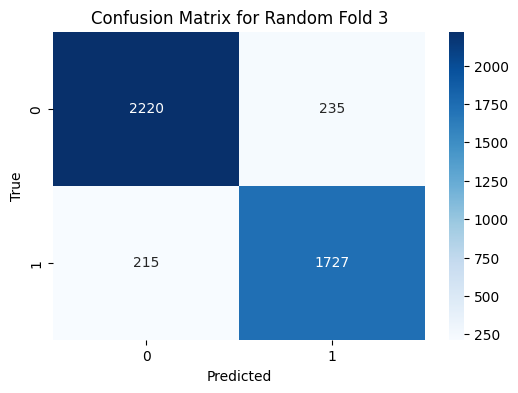

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2455
           1       0.88      0.89      0.88      1942

    accuracy                           0.90      4397
   macro avg       0.90      0.90      0.90      4397
weighted avg       0.90      0.90      0.90      4397

Random Fold 4
ROC AUC: 0.97
Confusion Matrix:
[[2172  267]
 [ 207 1751]]


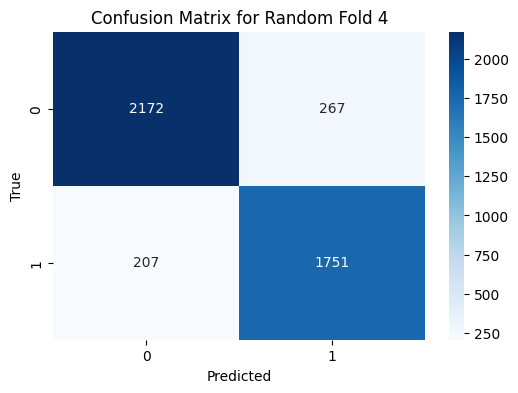

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2439
           1       0.87      0.89      0.88      1958

    accuracy                           0.89      4397
   macro avg       0.89      0.89      0.89      4397
weighted avg       0.89      0.89      0.89      4397

Random Fold 5
ROC AUC: 0.97
Confusion Matrix:
[[2230  290]
 [ 180 1697]]


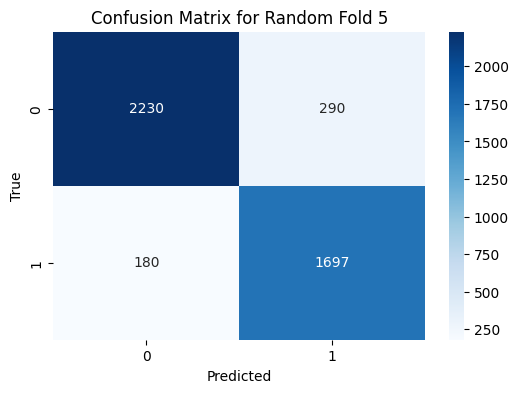

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      2520
           1       0.85      0.90      0.88      1877

    accuracy                           0.89      4397
   macro avg       0.89      0.89      0.89      4397
weighted avg       0.89      0.89      0.89      4397

Average ROC AUC: 0.97


In [20]:
#кросс валидация на случайных фолдах
cv_with_strategy(c_val, 'HLC', n_splits=5, method='random')

In [23]:
N = len(c_val)
val_len = int(0.1 * N)         # 10% валидации
n_splits = (N - int(0.5 * N)) // val_len  # сколько фолдов получится,тут 5

tscv = TimeSeriesSplit(
    n_splits=n_splits,
    test_size=val_len,
    gap=0  
)

X = c_val.drop(columns=["HLC", "timestamp", "Общее количество облачности"], errors="ignore")
y = c_val["HLC"]

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    print(f"Fold {fold}: train={len(train_idx)}, valid={len(val_idx)}")


Fold 1: train=10996, valid=2198
Fold 2: train=13194, valid=2198
Fold 3: train=15392, valid=2198
Fold 4: train=17590, valid=2198
Fold 5: train=19788, valid=2198



=== Fold 1 ===
train: 12935 (50.0%) | valid: 2586 (10.0%)
Learning rate set to 0.059637
0:	test: 0.7729160	best: 0.7729160 (0)	total: 30ms	remaining: 30s
100:	test: 0.8305251	best: 0.8307680 (88)	total: 1.55s	remaining: 13.8s
200:	test: 0.8345110	best: 0.8347051 (197)	total: 3.11s	remaining: 12.3s
300:	test: 0.8338695	best: 0.8352838 (236)	total: 4.66s	remaining: 10.8s
400:	test: 0.8336495	best: 0.8352838 (236)	total: 6.2s	remaining: 9.27s
500:	test: 0.8341673	best: 0.8352838 (236)	total: 7.74s	remaining: 7.71s
600:	test: 0.8333596	best: 0.8352838 (236)	total: 9.28s	remaining: 6.16s
700:	test: 0.8329062	best: 0.8352838 (236)	total: 10.8s	remaining: 4.62s
800:	test: 0.8323329	best: 0.8352838 (236)	total: 12.4s	remaining: 3.08s
900:	test: 0.8307523	best: 0.8352838 (236)	total: 14s	remaining: 1.53s
999:	test: 0.8296486	best: 0.8352838 (236)	total: 15.5s	remaining: 0us

bestTest = 0.8352837774
bestIteration = 236

Shrink model to first 237 iterations.
ROC AUC (fold 1): 0.8353


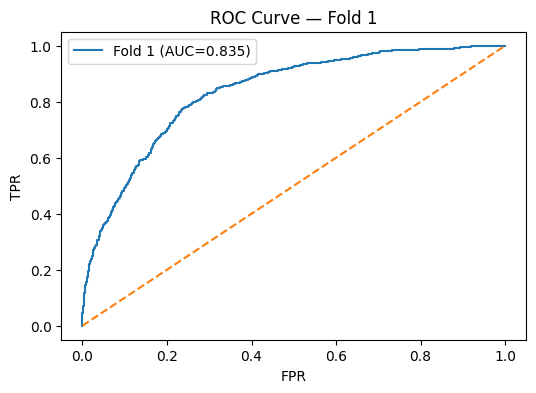

Confusion Matrix (valid):
[[1007  400]
 [ 217  962]]


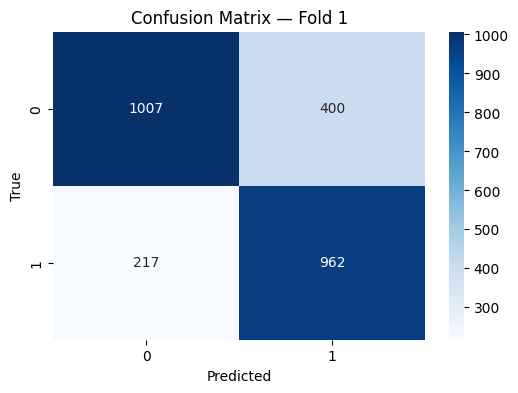

Classification Report (valid):
              precision    recall  f1-score   support

           0     0.8227    0.7157    0.7655      1407
           1     0.7063    0.8159    0.7572      1179

    accuracy                         0.7614      2586
   macro avg     0.7645    0.7658    0.7613      2586
weighted avg     0.7696    0.7614    0.7617      2586


=== Fold 2 ===
train: 15521 (60.0%) | valid: 2586 (10.0%)
Learning rate set to 0.062383
0:	test: 0.7328542	best: 0.7328542 (0)	total: 19.6ms	remaining: 19.6s
100:	test: 0.7962321	best: 0.7962708 (97)	total: 1.56s	remaining: 13.9s
200:	test: 0.7984313	best: 0.7984313 (200)	total: 3.13s	remaining: 12.4s
300:	test: 0.7971664	best: 0.7989686 (207)	total: 4.65s	remaining: 10.8s
400:	test: 0.7975949	best: 0.7989686 (207)	total: 6.21s	remaining: 9.28s
500:	test: 0.7970351	best: 0.7989686 (207)	total: 7.76s	remaining: 7.73s
600:	test: 0.7961485	best: 0.7989686 (207)	total: 9.32s	remaining: 6.19s
700:	test: 0.7971870	best: 0.7989686 (207)	tot

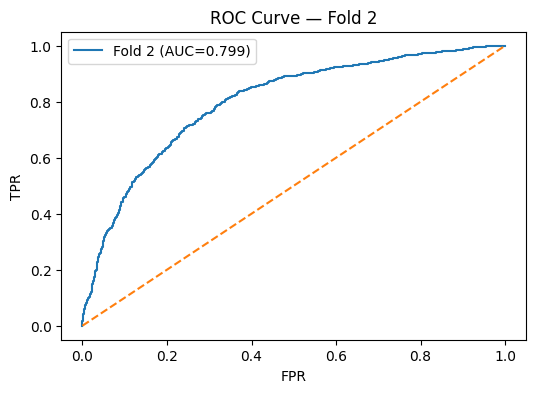

Confusion Matrix (valid):
[[1141  495]
 [ 227  723]]


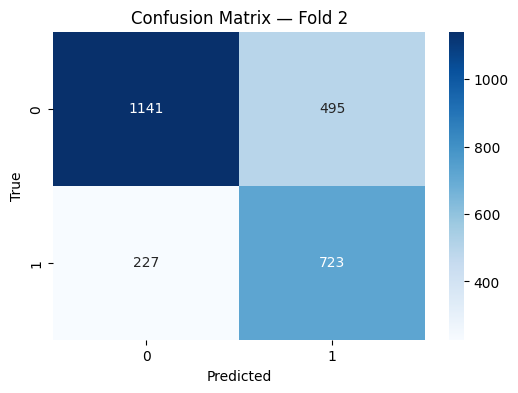

Classification Report (valid):
              precision    recall  f1-score   support

           0     0.8341    0.6974    0.7597      1636
           1     0.5936    0.7611    0.6670       950

    accuracy                         0.7208      2586
   macro avg     0.7138    0.7292    0.7133      2586
weighted avg     0.7457    0.7208    0.7256      2586


=== Fold 3 ===
train: 18107 (70.0%) | valid: 2586 (10.0%)
Learning rate set to 0.064803
0:	test: 0.7246523	best: 0.7246523 (0)	total: 19.6ms	remaining: 19.6s
100:	test: 0.7827829	best: 0.7830162 (99)	total: 1.62s	remaining: 14.4s
200:	test: 0.7852963	best: 0.7866706 (180)	total: 3.25s	remaining: 12.9s
300:	test: 0.7836968	best: 0.7866706 (180)	total: 4.86s	remaining: 11.3s
400:	test: 0.7830830	best: 0.7866706 (180)	total: 6.48s	remaining: 9.68s
500:	test: 0.7826146	best: 0.7866706 (180)	total: 8.09s	remaining: 8.06s
600:	test: 0.7821883	best: 0.7866706 (180)	total: 9.71s	remaining: 6.45s
700:	test: 0.7823919	best: 0.7866706 (180)	tot

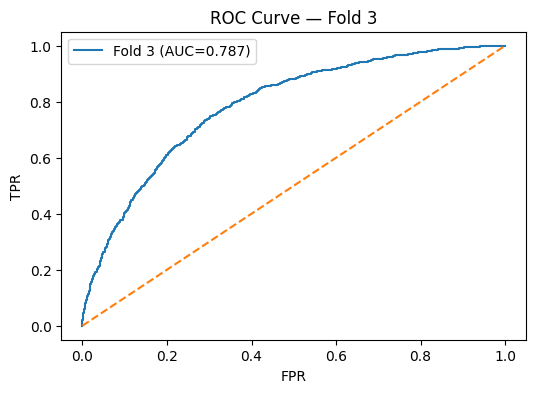

Confusion Matrix (valid):
[[1040  489]
 [ 252  805]]


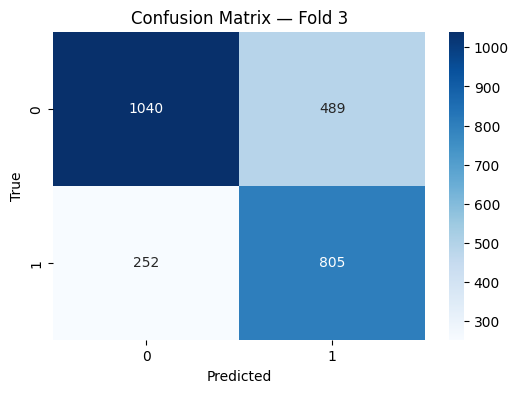

Classification Report (valid):
              precision    recall  f1-score   support

           0     0.8050    0.6802    0.7373      1529
           1     0.6221    0.7616    0.6848      1057

    accuracy                         0.7135      2586
   macro avg     0.7135    0.7209    0.7111      2586
weighted avg     0.7302    0.7135    0.7159      2586


=== Fold 4 ===
train: 20693 (80.0%) | valid: 2586 (10.0%)
Learning rate set to 0.066976
0:	test: 0.7148123	best: 0.7148123 (0)	total: 19.1ms	remaining: 19.1s
100:	test: 0.7713209	best: 0.7714039 (99)	total: 1.63s	remaining: 14.5s
200:	test: 0.7751971	best: 0.7756367 (196)	total: 3.25s	remaining: 12.9s
300:	test: 0.7760488	best: 0.7772858 (278)	total: 4.87s	remaining: 11.3s
400:	test: 0.7765292	best: 0.7772858 (278)	total: 6.48s	remaining: 9.68s
500:	test: 0.7757604	best: 0.7772858 (278)	total: 8.08s	remaining: 8.05s
600:	test: 0.7752986	best: 0.7772858 (278)	total: 9.7s	remaining: 6.44s
700:	test: 0.7751257	best: 0.7772858 (278)	tota

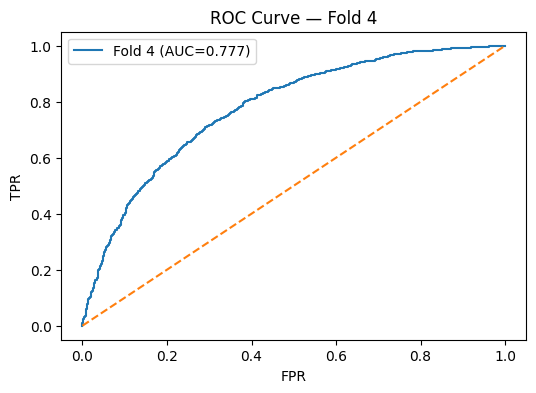

Confusion Matrix (valid):
[[1171  445]
 [ 304  666]]


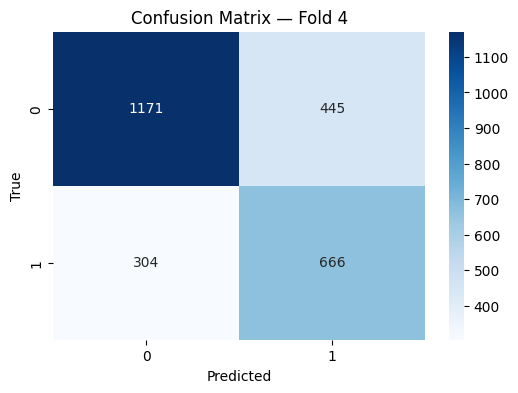

Classification Report (valid):
              precision    recall  f1-score   support

           0     0.7939    0.7246    0.7577      1616
           1     0.5995    0.6866    0.6401       970

    accuracy                         0.7104      2586
   macro avg     0.6967    0.7056    0.6989      2586
weighted avg     0.7210    0.7104    0.7136      2586


=== Fold 5 ===
train: 23279 (90.0%) | valid: 2586 (10.0%)
Learning rate set to 0.068952
0:	test: 0.7125630	best: 0.7125630 (0)	total: 18ms	remaining: 17.9s
100:	test: 0.7707847	best: 0.7707847 (100)	total: 1.64s	remaining: 14.6s
200:	test: 0.7744158	best: 0.7745545 (190)	total: 3.22s	remaining: 12.8s
300:	test: 0.7749975	best: 0.7752471 (271)	total: 4.81s	remaining: 11.2s
400:	test: 0.7752171	best: 0.7756936 (323)	total: 6.41s	remaining: 9.58s
500:	test: 0.7758735	best: 0.7761882 (492)	total: 8.02s	remaining: 7.99s
600:	test: 0.7748753	best: 0.7761882 (492)	total: 9.64s	remaining: 6.4s
700:	test: 0.7746780	best: 0.7761882 (492)	total

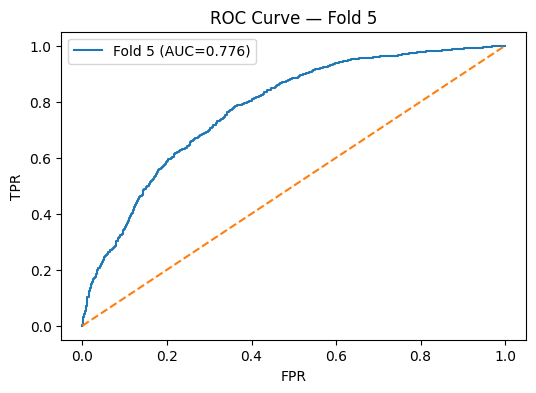

Confusion Matrix (valid):
[[1129  512]
 [ 268  677]]


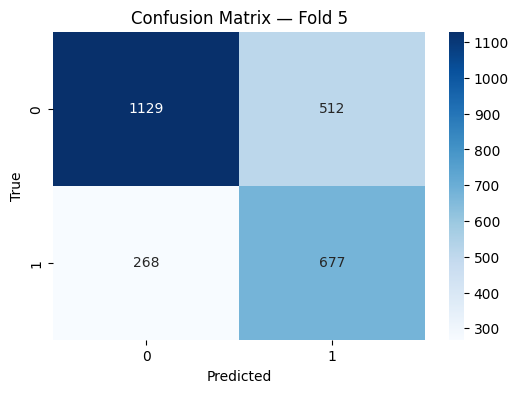

Classification Report (valid):
              precision    recall  f1-score   support

           0     0.8082    0.6880    0.7433      1641
           1     0.5694    0.7164    0.6345       945

    accuracy                         0.6984      2586
   macro avg     0.6888    0.7022    0.6889      2586
weighted avg     0.7209    0.6984    0.7035      2586


==== Average ROC AUC across folds: 0.7949 ± 0.0218 ====


In [26]:
# КРОССВАЛИДАЦИЯ для временных рядов
# --- 0) Сортировка по времени (важно для временных рядов) ---
df_sorted = df.sort_values("timestamp").reset_index(drop=True)

# --- 1) Формирование X/y и удаление колонок ---
drop_cols = ["timestamp", "Общее количество облачности"]
X = df_sorted.drop(columns=["HLC"] + [c for c in drop_cols if c in df_sorted.columns], errors="ignore")
y = df_sorted["HLC"].astype(int)

# --- 2) Настройка walk-forward TimeSeriesSplit ---
N = len(df_sorted)
val_len = int(0.1 * N)                     # 10% на валид в каждом фолде
n_splits = (N - int(0.5 * N)) // max(1, val_len)  # сколько блоков поместится от старта в 50%

# Если данных немного, гарантируем хотя бы 1 фолд
n_splits = max(1, n_splits)

tscv = TimeSeriesSplit(
    n_splits=n_splits,
    test_size=val_len,
    gap=0  # при лаговых фичах/скользящих окнах можно сделать gap >= max_lag
)

# --- 4) Параметры модели ---
model_params = dict(
    iterations=1000,
    loss_function="Logloss",
    auto_class_weights="Balanced",  # при дисбалансе
    eval_metric="AUC",
    use_best_model=True,
    verbose=100,
    random_seed=7
)

# --- 5) Обучение по фолдам и сбор метрик ---
roc_list = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val,   y_val   = X.iloc[val_idx],   y.iloc[val_idx]

    print(f"\n=== Fold {fold} ===")
    print(f"train: {len(train_idx)} ({len(train_idx)/N:.1%}) | valid: {len(val_idx)} ({len(val_idx)/N:.1%})")

    model = CatBoostClassifier(**model_params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        #plot=True  # если среда поддерживает интерактивные графики CatBoost
    )

    # Предсказания
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred  = (y_val_proba >= 0.5).astype(int)  # при желании порог можно подбирать по valid

    # Метрики
    roc_auc = roc_auc_score(y_val, y_val_proba)
    roc_list.append(roc_auc)
    print(f"ROC AUC (fold {fold}): {roc_auc:.4f}")

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve — Fold {fold}")
    plt.legend()
    plt.show()

    # Матрица ошибок
    cm = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix (valid):")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix — Fold {fold}')
    plt.show()

    # Отчёт
    print("Classification Report (valid):")
    print(classification_report(y_val, y_val_pred, digits=4))

# --- 6) Финальный вывод средней метрики ---
avg_auc = float(np.mean(roc_list)) if len(roc_list) > 0 else float("nan")
std_auc = float(np.std(roc_list)) if len(roc_list) > 0 else float("nan")
print(f"\n==== Average ROC AUC across folds: {avg_auc:.4f} ± {std_auc:.4f} ====")


ROC AUC: 0.8221
Confusion Matrix:
[[1810  647]
 [ 368 1054]]


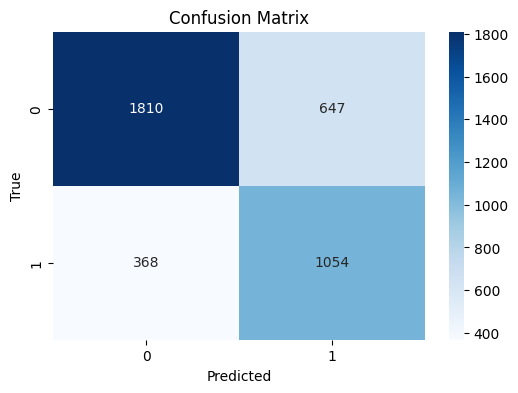

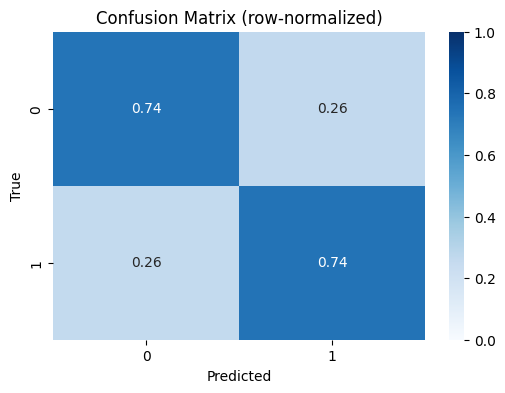

In [58]:
y_test = test["HLC"]
X_test = test.drop(columns=["HLC"])
X_test = X_test.iloc[:, :-2]

# вероятности положительного класса
y_pred_proba = model.predict_proba(X_test)[:, 1]

# бинарный прогноз
y_pred = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 4))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# --- Нормированная матрица ошибок (по строкам: доли внутри истинного класса) ---
cm_norm_true = confusion_matrix(y, y_pred, normalize='true')

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_norm_true,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=[0, 1],
    yticklabels=[0, 1],
    vmin=0, vmax=1
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (row-normalized)')
plt.show()